   id  age  gender   FT3    FT4    TSH   TPO   TGAb  site  echo_pattern  \
0   1   46       1  4.34  12.41  1.677  0.43   0.98     0             0   
1   2   61       1  5.40  16.26  2.905  0.45   1.91     0             0   
2   3   44       1  3.93  13.39  1.823  9.15  26.25     0             0   
3   5   29       0  3.70  13.98  1.293  0.15   0.81     0             0   
4   6   37       1  3.60  14.56  0.938  0.13  21.22     0             0   

   multifocality  size  shape  margin  calcification  echo_strength  \
0              0   4.6      0       0              0              4   
1              0   4.2      0       1              1              4   
2              0   0.7      0       1              0              4   
3              1   1.0      1       1              1              4   
4              0   0.7      0       1              1              4   

   blood_flow  composition  mal  multilateral  
0           0            1    1             1  
1           1            2

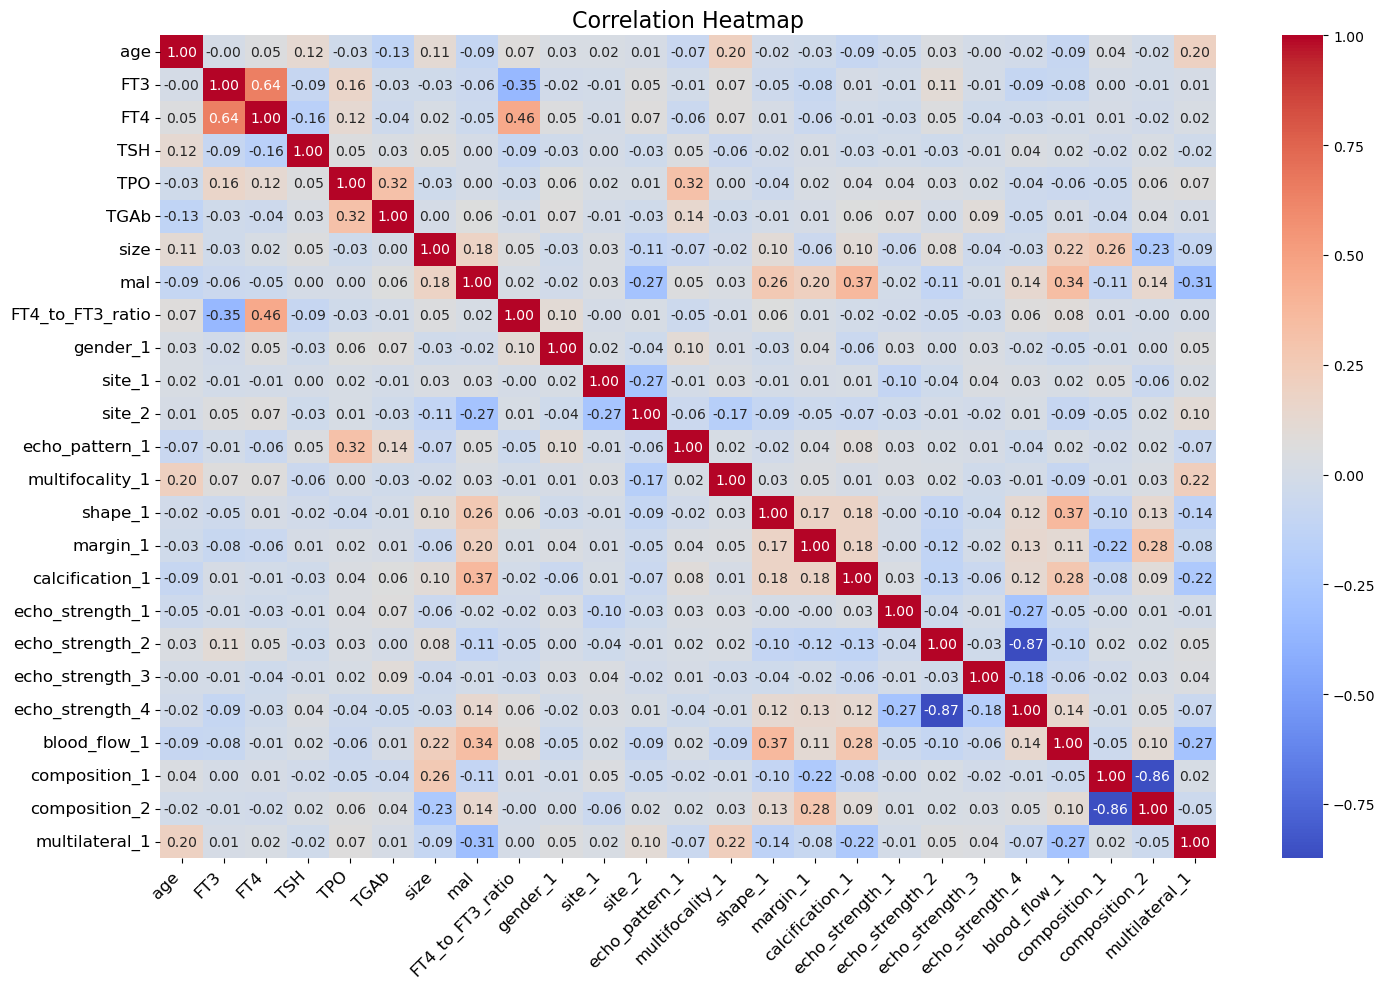

Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Model: RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

Tuning hyperparameters for XGBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}
Best XGBoost Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_t

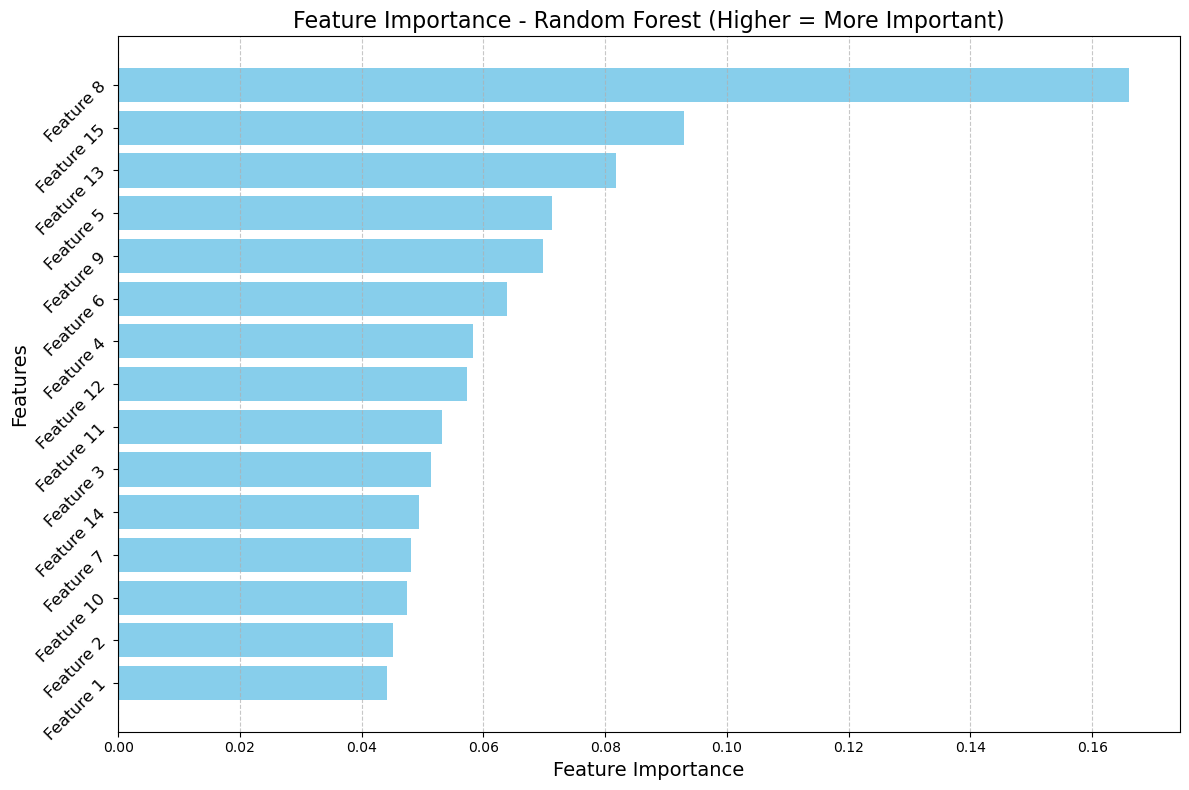

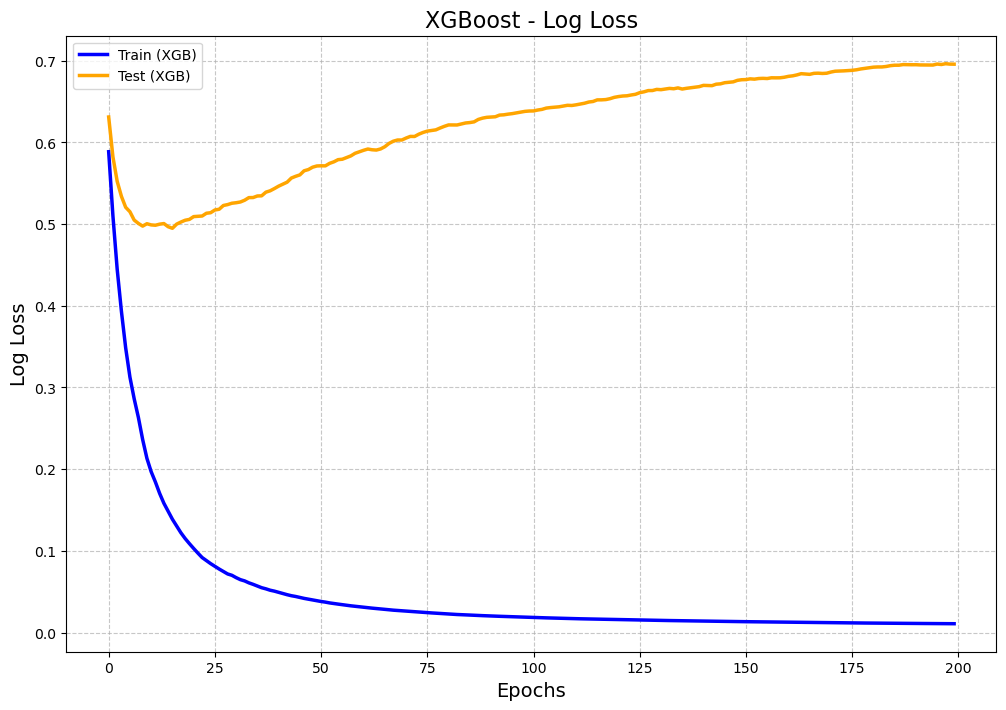

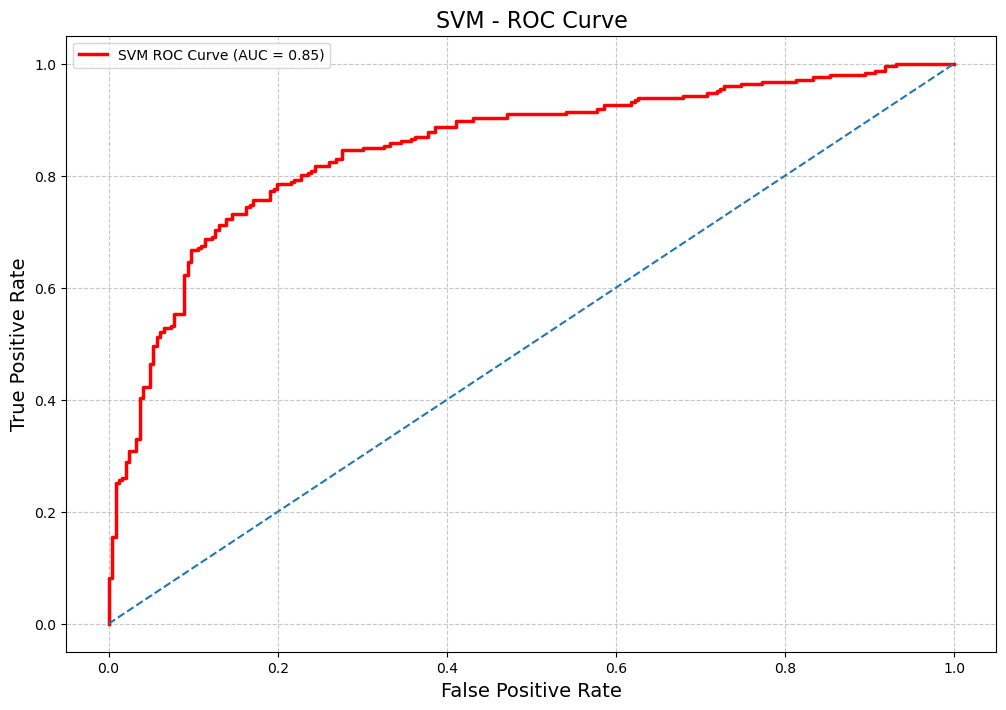

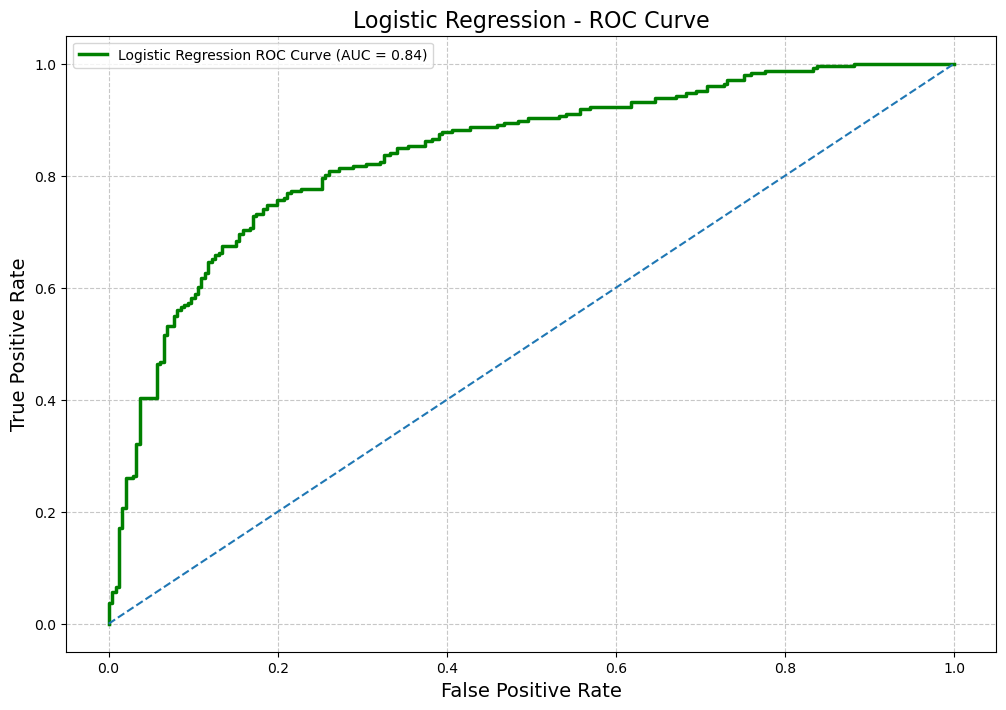

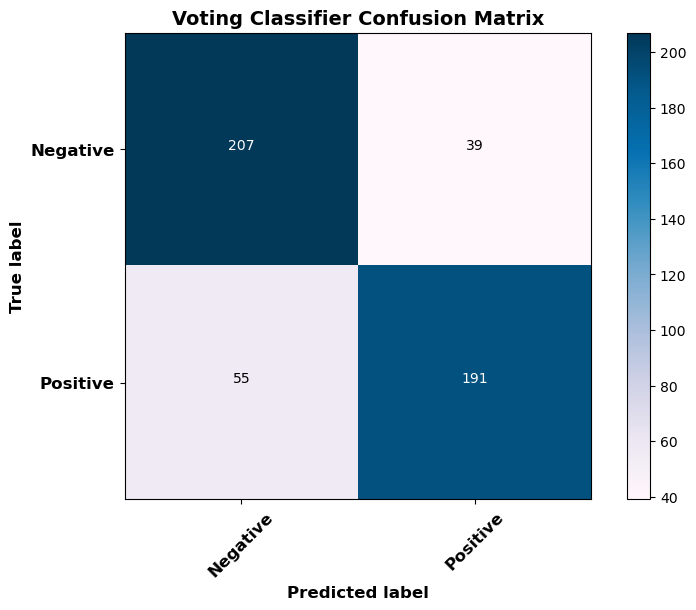

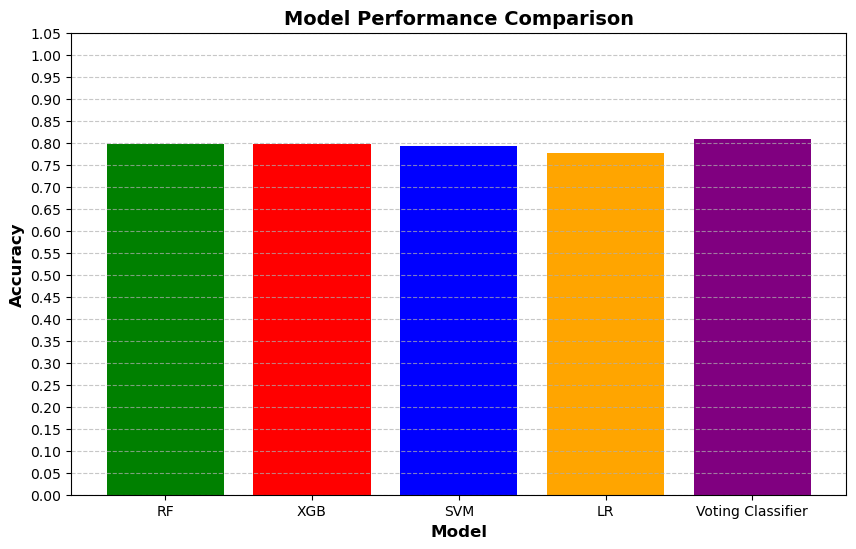

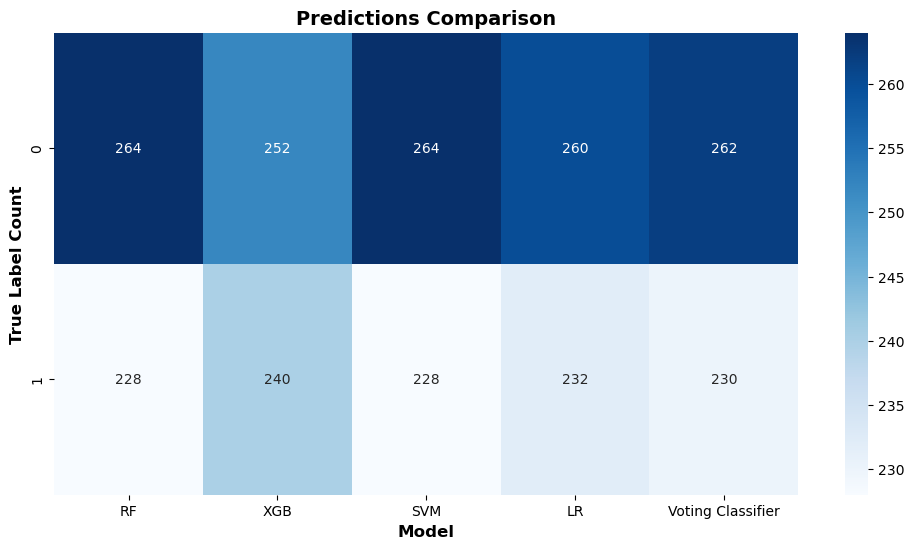

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV

# Assuming X_train, X_test, y_train, y_test are already defined
import numpy as np
import pandas as pd
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv(r'C:\Users\nagar\Downloads\ML PROJECTS\thyroid_clean.csv')

# Display basic information about the dataframe
print(df.head())
print(f"Shape of the dataframe: {df.shape}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")
df = df.drop_duplicates()

# Drop 'id' column if it exists
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Convert categorical features to 'category' dtype
categorical_features = ['gender', 'site', 'echo_pattern', 'multifocality', 'shape', 
                        'margin', 'calcification', 'echo_strength', 'blood_flow', 
                        'composition', 'multilateral']
df[categorical_features] = df[categorical_features].astype('category')

# Feature extraction
df['FT4_to_FT3_ratio'] = df['FT4'] / df['FT3']
df = pd.get_dummies(df, drop_first=True)

# Feature Scaling
scaler = StandardScaler()
continuous_features = ['age', 'FT3', 'FT4', 'TSH', 'TPO', 'TGAb', 'size', 'FT4_to_FT3_ratio']
df[continuous_features] = scaler.fit_transform(df[continuous_features])

# Correlation heatmap
plt.figure(figsize=(15, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 10})

# Tilt feature names by 45 degrees
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.title('Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()


# Define features (X) and target (y)
X = df.drop(columns=['mal'])  # Features
y = df['mal']  # Target variable

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Preserve 95% of variance
X_res = pca.fit_transform(X_res)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

# Define models separately
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
svc = SVC(kernel='rbf', random_state=42, probability=True)
lr = LogisticRegression(random_state=42)

# Define hyperparameters for each model
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10]
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

param_grid_lr = {
    'C': [0.1, 1, 10]
}

# Perform GridSearchCV for each model separately
best_models = {}

for name, model, param_grid in [('Random Forest', rf, param_grid_rf),
                                ('XGBoost', xgb, param_grid_xgb),
                                ('SVM (RBF Kernel)', svc, param_grid_svc),
                                ('Logistic Regression', lr, param_grid_lr)]:
    print(f"Tuning hyperparameters for {name}...")
    grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best {name} Model: {best_models[name]}\n")

# Use the best models to create the VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('rf', best_models['Random Forest']),
    ('xgb', best_models['XGBoost']),
    ('svc', best_models['SVM (RBF Kernel)']),
    ('lr', best_models['Logistic Regression'])
], voting='soft')

# Train and evaluate the VotingClassifier
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Voting Classifier - Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Define feature names
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns
else:
    feature_names = [f'Feature {i+1}' for i in range(X_train.shape[1])]

# Random Forest Feature Importance
plt.figure(figsize=(12, 8))
importances = best_models['Random Forest'].feature_importances_
indices = np.argsort(importances)[::-1]

# Bar plot with feature names tilted by 45 degrees
plt.barh(range(len(indices)), importances[indices], color='skyblue', align='center')
plt.yticks(range(len(indices)), np.array(feature_names)[indices], fontsize=12, rotation=45, ha='right')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importance - Random Forest (Higher = More Important)', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have top feature at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 2. Training and Loss Curves for XGB, SVC, and LR
# XGB Training Curve
evals = [(X_train, y_train), (X_test, y_test)]
best_models['XGBoost'].fit(X_train, y_train, eval_set=evals, verbose=False)

results = best_models['XGBoost'].evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 8))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train (XGB)', color='blue', linewidth=2.5)
plt.plot(x_axis, results['validation_1']['logloss'], label='Test (XGB)', color='orange', linewidth=2.5)
plt.title('XGBoost - Log Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# SVM Training Curve (using Calibration for probability estimates)
svc_calibrated = CalibratedClassifierCV(best_models['SVM (RBF Kernel)'], method='sigmoid')
svc_calibrated.fit(X_train, y_train)
svc_probs = svc_calibrated.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, svc_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, label=f'SVM ROC Curve (AUC = {roc_auc:.2f})', color='red', linewidth=2.5)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('SVM - ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Logistic Regression ROC Curve
y_pred_proba_lr = best_models['Logistic Regression'].predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, label=f'Logistic Regression ROC Curve (AUC = {roc_auc:.2f})', color='green', linewidth=2.5)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('Logistic Regression - ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Confusion matrix for Voting Classifier
conf_matrix_voting = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_voting, interpolation='nearest', cmap=plt.cm.PuBu)
plt.title('Voting Classifier Confusion Matrix', fontsize=14, fontweight='bold')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45, fontsize=12, fontweight='bold')
plt.yticks(tick_marks, ['Negative', 'Positive'], fontsize=12, fontweight='bold')

thresh = conf_matrix_voting.max() / 2.
for i, j in np.ndindex(conf_matrix_voting.shape):
    plt.text(j, i, format(conf_matrix_voting[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix_voting[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted label', fontsize=12, fontweight='bold')
plt.grid(False)
plt.show()

# Bar chart comparing model accuracies
model_names = ['RF', 'XGB', 'SVM', 'LR', 'Voting Classifier']
accuracies = [
    accuracy_score(y_test, best_models['Random Forest'].predict(X_test)),
    accuracy_score(y_test, best_models['XGBoost'].predict(X_test)),
    accuracy_score(y_test, best_models['SVM (RBF Kernel)'].predict(X_test)),
    accuracy_score(y_test, best_models['Logistic Regression'].predict(X_test)),
    accuracy
]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['green', 'red', 'blue', 'orange', 'purple'])
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.gca().set_yticks(np.arange(0, 1.1, 0.05))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Prediction comparison heatmap
predictions = {
    'RF': best_models['Random Forest'].predict(X_test),
    'XGB': best_models['XGBoost'].predict(X_test),
    'SVM': best_models['SVM (RBF Kernel)'].predict(X_test),
    'LR': best_models['Logistic Regression'].predict(X_test),
    'Voting Classifier': y_pred
}

predictions_df = pd.DataFrame(predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(predictions_df.apply(lambda x: x.value_counts(), axis=0).fillna(0), annot=True, cmap='Blues', fmt='g')
plt.title('Predictions Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('True Label Count', fontsize=12, fontweight='bold')
plt.show()
